# Work In Progress (WIP)



# 3. Multi-qubit gates and algorithms

In [1]:
# Specific install for Kaggle Notebooks environment
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Kaleido is used to convert Plotly to static png
!pip install -Uqq kaleido
!pip install -Uqq skq

# skq

In previous notebooks we got an extensive overview of how to work with a single qubit. In this notebook we will generalize to multiple qubits and finally look at meaningful algorithms that quantum computing offers. The previous notebooks gave you a solid toolbox from which to construct these algorithms. From here we will focus more on applying gates to construct quantum circuits.

To avoid having to construct gates and concepts from scratch each time we will use the [skq](https://github.com/CarloLepelaars/skq) library. I built this library so you can easily play with quantum concepts (in NumPy) and build your own algorithms. These circuits can then be converted to popular quantum frameworks like [Qiskit](https://github.com/Qiskit/qiskit), [PennyLane](https://github.com/PennyLaneAI/pennylane), [PyQuil](https://github.com/rigetti/pyquil) and [OpenQASM](https://openqasm.com/intro.html) so you can run them on real quantum computers.

All the quantum logic gates we talked about in previous notebooks can be found in the `skq.gates.qubit` module. We will also heavily use `Concat` for multi-qubit gates and `Circuit` for quantum circuits. These are relatively simple objects, but can be extended to any complex circuit.

In [31]:
import numpy as np

from skq.gates.qubit import X, H, I, CX, CCX, SWAP, CSwap
from skq.circuits import Concat, Circuit, BellStates

import plotly.graph_objects as go

# Fix Plotly rendering in Jupyter forks.
# If you are running this notebook locally you can comment this out.
# This allows you to play with interactive Plotly plots.
import plotly.io as pio
pio.renderers.default = 'png'

In [3]:
H()

H([[ 0.70710678+0.j,  0.70710678+0.j],
   [ 0.70710678+0.j, -0.70710678+0.j]])

In [4]:
X()

X([[0.+0.j, 1.+0.j],
   [1.+0.j, 0.+0.j]])

In [5]:
CX()

CX([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
    [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
    [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
    [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

Later in this course we will make more use of converting quantum gates and circuits to other frameworks, like IBM's [Qiskit](https://github.com/Qiskit/qiskit). This enables us to run our algorithms on real quantum computers in the cloud. 

In [6]:
CX().to_qiskit()

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])

Another popular standard for defining quantum circuits is [OpenQASM](https://openqasm.com/intro.html). You can think of OpenQASM like a very low-level language (i.e. assembly language) for quantum computers. We will devote a separate notebook to go more in-depth into OpenQASM. For now understand that we have the option to convert `skq` circuits to OpenQASM.

In [7]:
CX().to_qasm(qubits=[0, 1])

'cx q[0], q[1];'

## Bell State

One of the first breakthroughs in quantum was the discovery and application of a completely entangled state called the Bell state. In this state 2 qubits are 100% correlated to each other. This enables use cases that are not possible classically like quantum communication and quantum teleportation.

The simplest Bell State ($| \Psi^+ \rangle$) is defined as follows:

$$
| \Psi^+ \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

To prepare entanglement we first initialize two qubits ($|00 \rangle = [1, 0, 0, 0]$) and put the 1st qubit in the superposition state with a Hadamard ($H$) gate. The 1st qubit is not changed in this first step so the $I$ gate is applied.



# TODO Explain how concat comes about with Kronecker product

In [8]:
step1 = Concat([H(), I()])
step1([1, 0, 0, 0])

H([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j])

The two qubits are then entangled using the CNOT ($CX$) gate.

In [9]:
step2 = CX()
step2(step1([1, 0, 0, 0]))

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Now we have a state that is completely entangled. The measurement of the two qubits will always be the same, even if the outcome is random. These qubits can be separated over large distances and this enables secure communication, among other things.

Now construct the complete circuit and verify that we implemented it correctly.

# TODO Explain structure of Circuit in skq

In [10]:
bell_circuit = Circuit([step1, step2])
bell_state = bell_circuit([1, 0, 0, 0])
bell_state

array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j])

Recall that measurement can be done by taking the absolute square of the state vector and sampling from it.

You will see that the only possible outcomes are $00$ and $11$ and they are roughly evenly distributed. On real quantum computers there is noise so there is a small chance of still measuring $01$ or $10$.

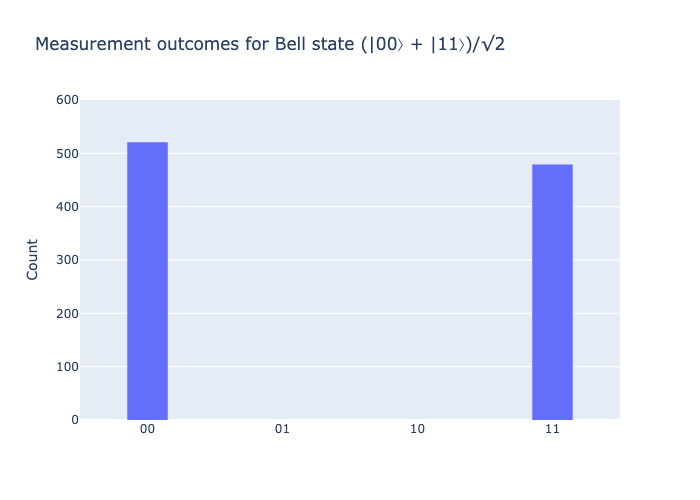

In [11]:
def measure_state(s):
    # Absolute value squared gives us the probability distribution from the statevector
    p = np.abs(s) ** 2
    # Sample from probability distribution to get classical bits
    # Only states |00⟩ and |11⟩ should have non-zero probability for Bell state
    return np.random.choice([0, 3], p=[p[0], p[3]])  # Only sample from states with non-zero amplitude

# Generate 1000 samples
samples = [measure_state(bell_state) for _ in range(1000)]

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=samples,
    xbins=dict(
        start=-0.5,
        end=3.5,
        size=1
    ),
))
fig.update_layout(
    title="Measurement outcomes for Bell state (|00⟩ + |11⟩)/√2",
    xaxis=dict(
        tickmode="array",
        tickvals=[0, 1, 2, 3],  # Show all possible states
        ticktext=["00", "01", "10", "11"]
    ),
    yaxis=dict(
        title="Count",
        range=[0, 600]
    ),
    bargap=0.7  # Add some gap between bars
)
fig.show()

In `skq` we can directly use the Bell states as a building block in our circuits.

In [17]:
bell_state2 = BellStates().get_bell_state(1)([1,0,0,0])
assert np.allclose(bell_state, bell_state2)

# Work In Progress (WIP)

# TODO Convert Bell circuit to Qiskit and display circuit

## GHZ State

A GHZ State generalizes the notion of a Bell state to $n$ qubits. This creates a fully entangled state between all the qubits.

In [12]:
# TODO Show generalization of Bell state to n qubits

## Toffoli (CCX) Gate

A Toffoli ($CCX$) gate is similar to a CNOT gate, but for 3 qubits. If the 1st 2 qubits are 1, the 3rd qubit is flipped. We therefore say it has 2 control qubits. A gate for 3 qubits requires a $2^3 \times 2^3 = 8 \times 8$ matrix to represent classically. You can see why it becomes infeasible to simulate quantum circuits for many qubits on a classical computer.

In [32]:
CCX()

CCX([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

We can construct a Toffoli gate from CNOT gates. 

In [13]:
# Construct Toffoli from CNOT gates

## SWAP

In [20]:
SWAP()

SWAP([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
      [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
      [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [23]:
[0,1,0,0] @ SWAP()

SWAP([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

# TODO Explain SWAP gate and significance for real (transpiled) quantum circuits

## CSWAP

In [26]:
CSwap()

CSwap([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [29]:
[0,0,0,0,0,1,0,0] @ CSwap()

CSwap([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])

# Work In Progress (WIP)